# Lab 4.Regularization

## Regularization for linear regression

import essential files

In [115]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import csv

import training dataset

In [116]:
with open("lin_reg_training.csv") as f:
    csv_reader = csv.reader(f)
    examples = []
    for row in csv_reader:
        examples.append([float(cell) for cell in row])
    data = np.array(examples)
    x_train = data[:, 0]
    y_train = data[:, 1]
    X = np.concatenate([np.ones((data.shape[0], 1)), data[:, 0].reshape(-1, 1)], axis=1)
    y = y_train


import test dataset

In [117]:
with open("lin_reg_test.csv") as f:
    csv_reader = csv.reader(f)
    examples = []
    for row in csv_reader:
        examples.append([float(cell) for cell in row])
    data = np.array(examples)
    x_test = data[:, 0]
    y_test = data[:, 1]
    x_test_before_scale = x_test
    

comparison of train and test datasets

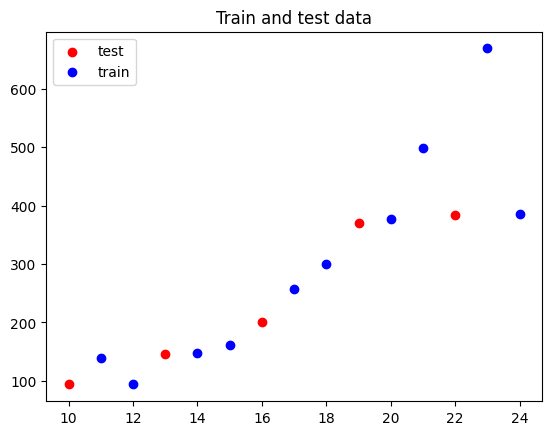

In [118]:
plt.scatter(x_test, y_test, color='red', label="test")
plt.scatter(x_train, y_train, color='blue', label="train")
plt.title("Train and test data")
plt.legend()
plt.show()

Rescale data using sklearn

In [119]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
x_train = x_train.reshape(-1,1)
x_train = standard_scaler.fit_transform(x_train)
x_test = x_test.reshape(-1,1)
x_test = standard_scaler.transform(x_test)

Expanding features with nonlinear combinations up to the sixth degree

In [120]:
from sklearn.preprocessing import PolynomialFeatures
 
poly_features = PolynomialFeatures(degree=6)
x_train = poly_features.fit_transform(x_train)

Functions for polynomial regression created on previous lessons 

In [121]:
# function for calculate predictions
def h_fun_poly(X, theta):
    '''
    :param X: ndarray postaci (n+1, m).
    :param theta: macierz parametrów do optymalizacji postaci (n+1, 1)
    :return: 
    '''
    return (theta.T @ X)


# calculate cost in linear regression
def calculate_cost_poly(X, y, theta):
    '''
    :param X: ndarray postaci (n+1, m).
    :param y: ndarray z wartościami referencyjnymi o wymiarze (1, m)
    :param theta: macierz parametrów do optymalizacji postaci (n+1, 1)
    :return: wartość f. kosztu
    '''
    m = np.size(X,1)
    J = 1/(2*m) * np.sum(np.power(h_fun_poly(X, theta) - y, 2))
    return J


# gradient decsent algorithm (packed to a function finally)
def gradient_descent_alg_poly(X, y, theta, eps, alpha):
    """Function optimizing theta params for function creating linear regression for X data.

    Args:
        X (np.array): data to predict
        y (np.array): real values
        theta (np.array): coefficents
        eps (_type_): error margin for cost fun
        alpha (_type_): learning rate

    Returns:
        tuple: (optimized theta coefficents, minimalized cost value)
    """
    cost_before = 0
    current_cost = 1000
    count=0
    
    while abs(current_cost - cost_before) > eps: # with abs output is more precise, but iterates much more times
        cost_before = calculate_cost_poly(X, y, theta)
        h_y_diff = (h_fun_poly(X, theta) - y)
        gradient = h_y_diff @ X.T
        theta = theta - alpha * gradient.T / X.shape[-1]
        current_cost = calculate_cost_poly(X, y, theta)
        count += 1
    print("number of iterations: ", count) # number of iterations
    print(f"Theta values: {theta}") # counted values
    minimalized_cost = current_cost
    print(f"cost: {round(minimalized_cost, 5)}") # estimated minimal cost

    return theta, minimalized_cost

Calculate regression for dataset

In [122]:
theta = np.zeros((7, 1))
alpha = 0.01
eps = 1e-10

theta, cost = gradient_descent_alg_poly(x_train.T, y_train, theta, eps, alpha)

number of iterations:  190296
Theta values: [[ 275.06854038]
 [  93.25913545]
 [ -31.83358187]
 [ 281.06603024]
 [ 178.71553604]
 [-123.53249453]
 [ -72.32627168]]
cost: 57.30885


Visualize fitting

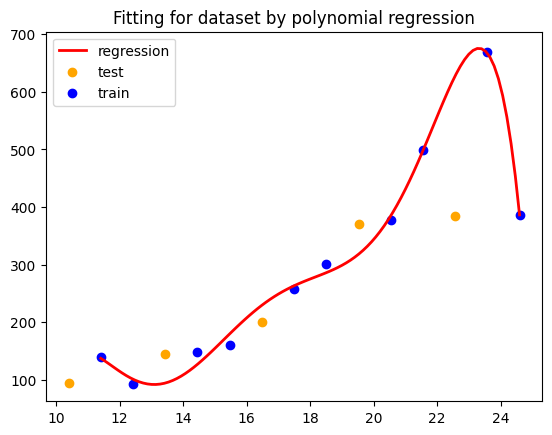

In [123]:
rescale_fun = lambda a: a*(13/3) + 18  # equation deducted by minimas and maximas
plt.title("Fitting for dataset by polynomial regression")
x_plot = np.linspace(np.min(x_train[:, 1]), np.max(x_train[:, 1]), 100)
x_plot = poly_features.fit_transform(x_plot.reshape(-1,1))
y_predicted = h_fun_poly(x_plot.T, theta).T.reshape(100)
plt.plot(rescale_fun(x_plot[:,1]), y_predicted, label='regression', color='red', linewidth=2)

plt.scatter(rescale_fun(x_test), y_test, color='orange', label="test")
plt.scatter(rescale_fun(x_train[:, 1]).reshape(10), y_train, color='blue', label="train")
plt.legend()
plt.show()

*Based on the chart before, regression is precise for train set, but has nothing common with testing data. This phenomenon is called overfitting. In next step I will try to manage it modyfying gradient descent algorithm*

### Regularization parameter in gradient descent algorithm
Modify function which calculates cost and whole algorithm with lambda variable, which going to forbid function to fit too much to the dataset

In [124]:
# calculate cost in linear regression
def calculate_cost_poly(X, y, theta, lambda_):
    '''
    :param X: ndarray postaci (n+1, m).
    :param y: ndarray z wartościami referencyjnymi o wymiarze (1, m)
    :param theta: macierz parametrów do optymalizacji postaci (n+1, 1)
    :return: wartość f. kosztu
    '''
    m = np.size(X,1)
    J = 1/(2*m) * np.sum(np.power(h_fun_poly(X, theta) - y, 2))
    theta_sum = (theta[1:, :]**2).sum()
    return J + theta_sum*lambda_/(2*m)


# gradient decsent algorithm (packed to a function finally)
def gradient_descent_alg_poly(X, y, theta, eps, alpha, lambda_):
    """Function optimizing theta params for function creating linear regression for X data.

    Args:
        X (np.array): data to predict
        y (np.array): real values
        theta (np.array): coefficents
        eps (_type_): error margin for cost fun
        alpha (_type_): learning rate

    Returns:
        tuple: (optimized theta coefficents, minimalized cost value)
    """
    cost_before = 0
    current_cost = 1000
    count=0
    
    while abs(current_cost - cost_before) > eps: # with abs output is more precise, but iterates much more times
        cost_before = calculate_cost_poly(X, y, theta, lambda_)
        h_y_diff = (h_fun_poly(X, theta) - y)
        gradient = h_y_diff @ X.T
        # XXX change here, theta calculating in another way, with lambda and theta regularzation parameters
        theta_reg = np.concatenate([np.zeros((1,1)), theta[1:, :]], axis=0)
        theta = theta - alpha * ((gradient.T) + lambda_*theta_reg) / X.shape[-1]
        current_cost = calculate_cost_poly(X, y, theta, lambda_)
        count += 1
    print("number of iterations: ", count) # number of iterations
    print(f"Theta values: {theta}") # counted values
    minimalized_cost = current_cost
    print(f"cost: {round(minimalized_cost, 5)}") # estimated minimal cost

    return theta, minimalized_cost

Apply change on function and visualize with regularization

In [125]:
def calculate_and_visualize_(lambda_):
    theta = np.zeros((7, 1))
    alpha = 0.01
    eps = 1e-10
    theta, cost = gradient_descent_alg_poly(x_train.T, y_train, theta, eps, alpha, lambda_)
    rescale_fun = lambda a: a*(13/3) + 18  # equation deducted by minimas and maximas
    plt.title(f"Fitting for dataset by polynomial regression for lambda = {lambda_}")
    x_plot = np.linspace(np.min(x_train[:, 1]), np.max(x_train[:, 1]), 100)
    x_plot = poly_features.fit_transform(x_plot.reshape(-1,1))
    y_predicted = h_fun_poly(x_plot.T, theta).T.reshape(100)
    plt.plot(rescale_fun(x_plot[:,1]), y_predicted, label='regression', color='red', linewidth=2)

    plt.scatter(rescale_fun(x_test), y_test, color='orange', label="test")
    plt.scatter(rescale_fun(x_train[:, 1]).reshape(10), y_train, color='blue', label="train")
    plt.legend()
    plt.show()

Test on different lambdas

number of iterations:  158246
Theta values: [[ 272.50082452]
 [ 101.36111713]
 [ -13.5486196 ]
 [ 266.02029622]
 [ 158.48933295]
 [-118.36007451]
 [ -66.72788806]]
cost: 123.52436


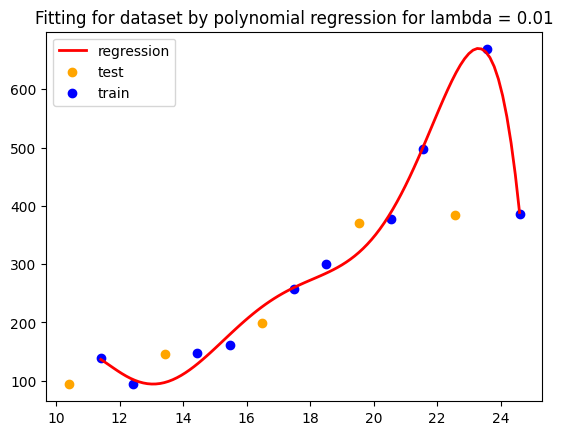

number of iterations:  63892
Theta values: [[266.7143642 ]
 [137.34425188]
 [ 37.30272431]
 [192.86755095]
 [ 96.79116222]
 [-92.45180783]
 [-48.81861984]]
cost: 547.71701


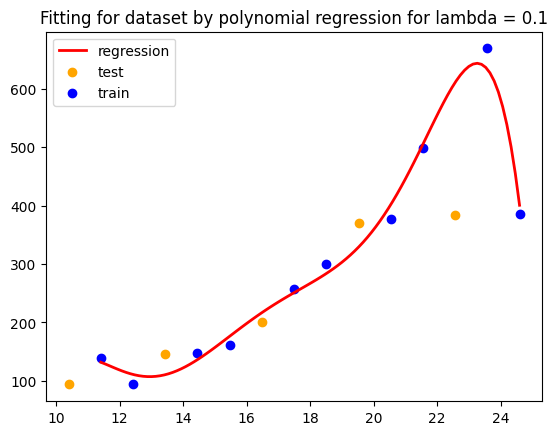

number of iterations:  10429
Theta values: [[278.2429289 ]
 [138.90219136]
 [ 41.71823262]
 [ 94.48919233]
 [ 43.02521116]
 [-47.19947816]
 [-26.47158802]]
cost: 2738.23083


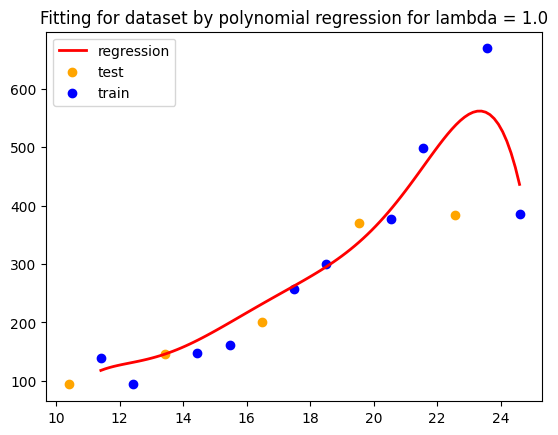

number of iterations:  2685
Theta values: [[300.09551756]
 [ 46.56897779]
 [  9.55135918]
 [ 31.36918478]
 [  8.50267032]
 [  1.6808663 ]
 [ -6.18444951]]
cost: 7364.79319


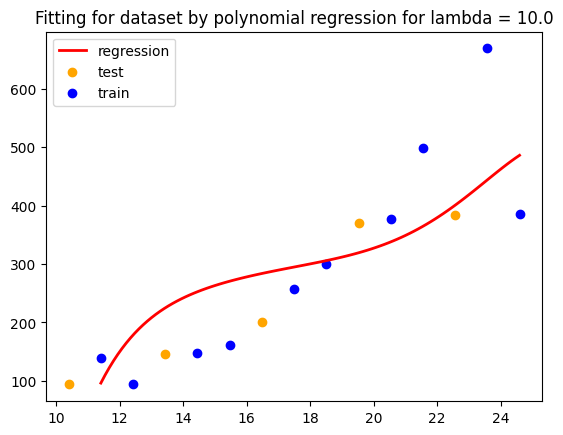

number of iterations:  2100
Theta values: [[304.81921238]
 [  8.55411383]
 [  1.00608009]
 [  9.5018836 ]
 [  0.74496764]
 [ 12.36680265]
 [ -1.1911166 ]]
cost: 10697.13101


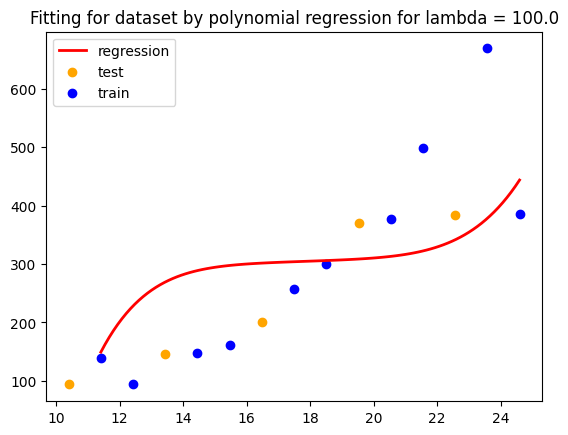

In [126]:
eps = 1e-5 # use bigger margin to optimize time
# testing on lambdas betweeen 10^-3 and 10^2 every 10 degree
for lambda_ in np.logspace(-2, 2, num=5, base=10): 
    calculate_and_visualize_(lambda_)

*It can be observed that the bigger lambda is, regression fits less. In my view, most acceptable lambda among tested is 10.*

## Regularization for logistic regression
*In this case, if it is already known that outcome of regulariztion is based on lambda ratio, only case connected with lambda will be implemented.*

load and visualizing another dataset

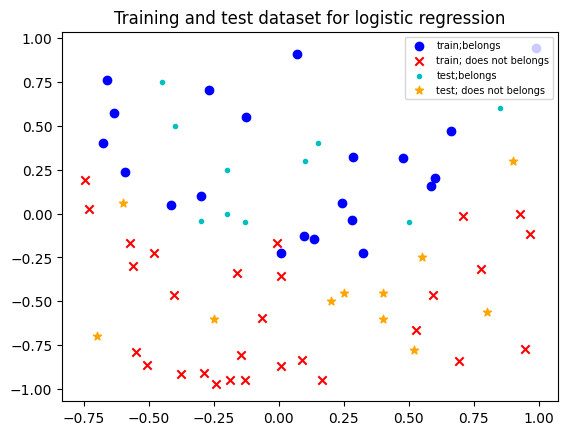

In [127]:
### training set
with open("logi_reg_training.csv") as f:
    csv_reader = csv.reader(f)
    examples = []
    for row in csv_reader:
        examples.append([float(cell) for cell in row])
    data = np.array(examples)
    y_train = data[:, 2:3].T
    x_train = data[:, :2].T
    x1 = data[:, :1].T
    x2 = data[:, 1:2].T
    X_train = np.concatenate([np.ones([1, x1.shape[1]]), x1, x2, x1**2, x2**2, x1**3, x2**3, x1*x2, x1**2 * x2 **2])

### testing set
with open("logi_reg_test.csv") as f:
    csv_reader = csv.reader(f)
    examples = []
    for row in csv_reader:
        examples.append([float(cell) for cell in row])
    data = np.array(examples)
    y_test = data[:, 2:3].T
    x_test = data[:, :2].T
    X_test = np.concatenate([np.ones([1, x_test.shape[1]]), x_test])

# plot train
belongs = np.where(y_train[0] == 1)[0]
not_belongs = np.where(y_train[0] == 0)[0]
plt.scatter(X_train[1][belongs], X_train[2][belongs], color='blue', marker='o', label='train;belongs')
plt.scatter(X_train[1][not_belongs], X_train[2][not_belongs], color='red', marker='x', label="train; does not belongs")

belongs_test = np.where(y_test[0] == 1)[0]
not_belongs_test = np.where(y_test[0] == 0)[0]
plt.scatter(X_test[1][belongs_test], X_test[2][belongs_test], color='c', marker='.', label='test;belongs')
plt.scatter(X_test[1][not_belongs_test], X_test[2][not_belongs_test], color='orange', marker='*', label="test; does not belongs")

plt.title("Training and test dataset for logistic regression")
plt.legend(fontsize=7, loc="upper right")
plt.show()

Functions for logistic regression modified by regularization parameter lambda

In [128]:
# function for calculate predictions - logistic
def h_fun_logi(X, theta):
    '''
    :param X: ndarray postaci (n+1, m).
    :param theta: macierz parametrów do optymalizacji postaci (n+1, 1)
    :return: 
    '''
    z = theta.T @ X
    h = 1.0 / (1.0 + np.exp(-z))
    return h


# calculate cost in logistic regression
def calculate_cost_logi(X, y, theta, lambda_):
    '''
    :param X: ndarray postaci (n+1, m).
    :param y: ndarray z wartościami referencyjnymi o wymiarze (1, m)
    :param theta: macierz parametrów do optymalizacji postaci (n+1, 1)
    :param lambda_: parametr regulujący stopień dopasowania
    :return: wartość f. kosztu
    '''
    m = X.shape[0]
    h = h_fun_logi(X, theta)
    y_1 = -y*np.log(h)
    y_0 = -(1-y)*np.log(1-h)
    sum_of_thetas = (theta[1:, :] ** 2).sum()
    cost = (y_1 + y_0).sum() / X.shape[1]
    return cost + sum_of_thetas * lambda_ / (2 * m)


# gradient descent algorithm case in logistic regression
def gradient_descent_alg_logi(X, y, theta, eps, alpha, lambda_):
    """Function optimizing theta params for function creating logistic regression for X data.

    Args:
        X (np.array): data to predict
        y (np.array): real values
        theta (np.array): coefficents
        eps (float): error margin for cost fun
        alpha (float): learning rate
        lambda_(float): 
    Returns:
        tuple: (optimized theta coefficents, minimalized cost value)
    """
    cost_before = 0
    current_cost = 1000
    count=0
    m=X.shape[-1]
    
    while abs(current_cost - cost_before) > eps: # with abs output is more precise, but iterates much more times
        cost_before = calculate_cost_logi(X, y, theta, lambda_)
        h_y_diff = (h_fun_logi(X, theta) - y)
        gradient = h_y_diff @ X.T
        # XXX added regularization parameter
        theta_reg = np.concatenate([np.zeros((1, 1)), theta[1:, :]], axis=0)
        theta = theta - alpha * (gradient.T  + lambda_ * theta_reg)/ m
        current_cost = calculate_cost_logi(X, y, theta, lambda_)
        count += 1
    print("number of iterations: ", count) # number of iterations
    print(f"Theta values: {theta}") # counted values
    minimalized_cost = current_cost
    print(f"cost: {round(minimalized_cost, 5)}") # estimated minimal cost

    return theta, minimalized_cost

Apply change on function and visualize with regularization (logistic)

In [129]:
def calculate_and_visualize_(lambda_):
    theta = np.zeros((9, 1))
    alpha = 0.01
    eps = 1e-8
    theta, cost = gradient_descent_alg_logi(X_train, y_train, theta, eps, alpha, lambda_)
    rescale_fun = lambda a: a*(13/3) + 18  # equation deducted by minimas and maximas
    plt.title(f"Fitting for dataset by polynomial regression for lambda = {lambda_}")
    
    # plot dataset
    belongs = np.where(y_train[0] == 1)[0]
    not_belongs = np.where(y_train[0] == 0)[0]
    plt.scatter(X_train[1][belongs], X_train[2][belongs], color='blue', marker='o', label='train;belongs')
    plt.scatter(X_train[1][not_belongs], X_train[2][not_belongs], color='red', marker='x', label="train; does not belongs")
    belongs_test = np.where(y_test[0] == 1)[0]
    not_belongs_test = np.where(y_test[0] == 0)[0]
    plt.scatter(X_test[1][belongs_test], X_test[2][belongs_test], color='c', marker='.', label='test;belongs')
    plt.scatter(X_test[1][not_belongs_test], X_test[2][not_belongs_test], color='orange', marker='*', label="test; does not belongs")
    x1_db = np.arange(X_train[1, :].min(), X_train[1, :].max(), 0.01)
    theta_horizontal = theta[1:].flatten()
    x2_db = -theta[0, 0] / theta[2, 0] - np.sum([(theta_horizontal[i] * x1_db ** (i+1)) / theta[2, 0] for i in range(len(theta_horizontal))], axis=0)
    x2_db_ = [-val-0.5 for val in x2_db]
    plt.plot(x1_db, x2_db_, '-m', label="decision boundary")

    plt.title(f"Fitting for dataset by logistic regression for lambda = {lambda_}")
    plt.legend(fontsize=7, loc="upper right")
    plt.show()

Test on different lambdas

number of iterations:  45137
Theta values: [[ 1.94548169]
 [ 1.85515749]
 [ 7.39637741]
 [-5.60162512]
 [-0.74657301]
 [-1.46319467]
 [ 2.44906245]
 [-0.39255701]
 [ 0.14564998]]
cost: 0.19495


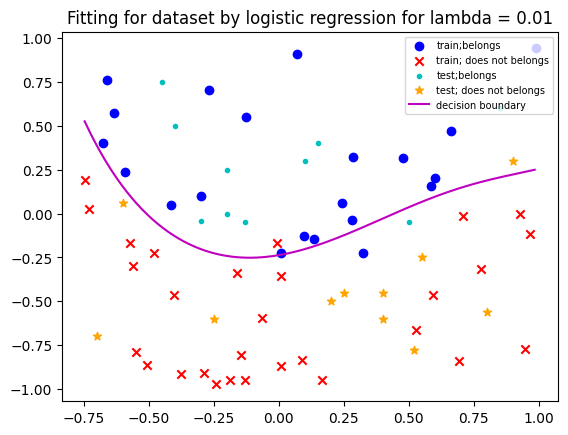

number of iterations:  11620
Theta values: [[ 0.88130815]
 [ 0.83914164]
 [ 4.34350493]
 [-2.24200552]
 [-0.56275788]
 [-0.73389118]
 [ 1.75665365]
 [-0.00726938]
 [ 0.05238592]]
cost: 0.30357


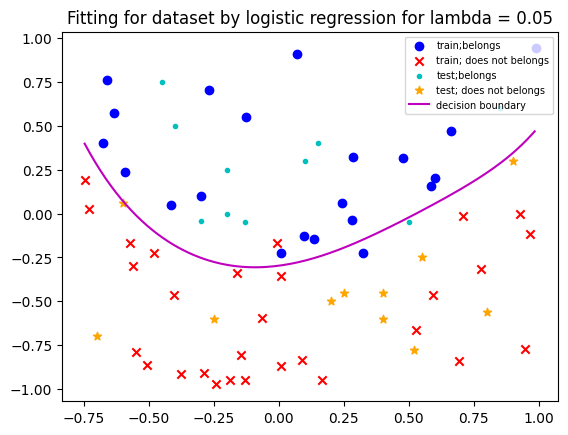

number of iterations:  5914
Theta values: [[ 0.5228461 ]
 [ 0.46365659]
 [ 3.26921582]
 [-1.21711326]
 [-0.48898812]
 [-0.46833818]
 [ 1.45283368]
 [ 0.01935585]
 [ 0.03282996]]
cost: 0.35948


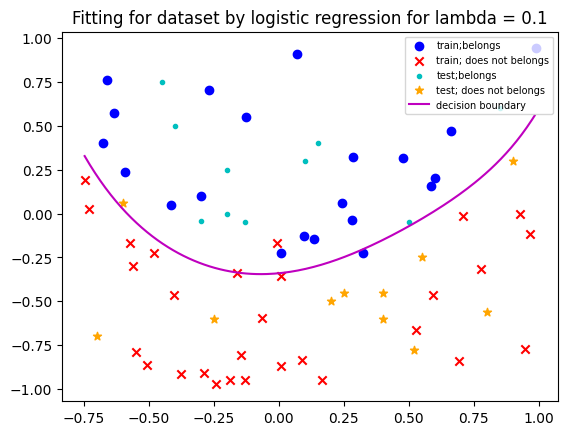

number of iterations:  56660
Theta values: [[ 0.71434129]
 [ 0.62859763]
 [ 3.28034261]
 [-1.80335814]
 [-0.41965138]
 [-0.55573192]
 [ 1.14572732]
 [-0.03505414]
 [ 0.07904333]]
cost: 0.71582


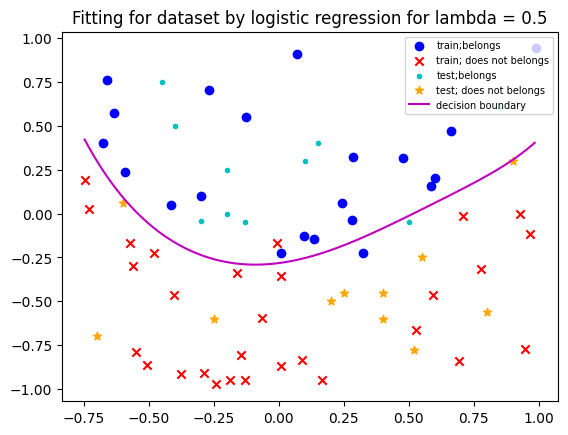

number of iterations:  33993
Theta values: [[ 0.44323083]
 [ 0.36983273]
 [ 2.44137949]
 [-1.05464482]
 [-0.36920557]
 [-0.37028447]
 [ 0.97865958]
 [ 0.00405251]
 [ 0.03941203]]
cost: 0.78862


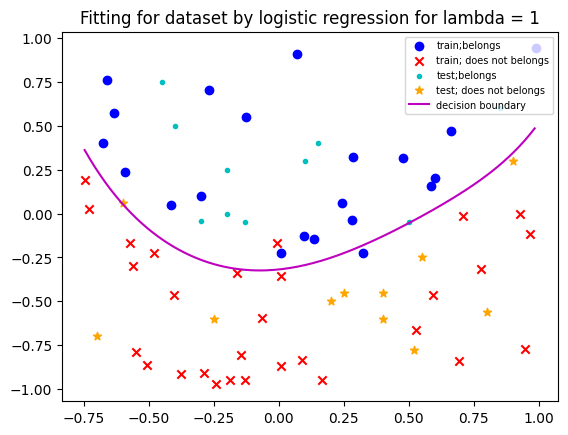

number of iterations:  5593
Theta values: [[-0.09221254]
 [ 0.04010869]
 [ 0.677283  ]
 [-0.09887655]
 [-0.15072257]
 [-0.0582964 ]
 [ 0.36640057]
 [ 0.00411362]
 [ 0.00348976]]
cost: 0.8746


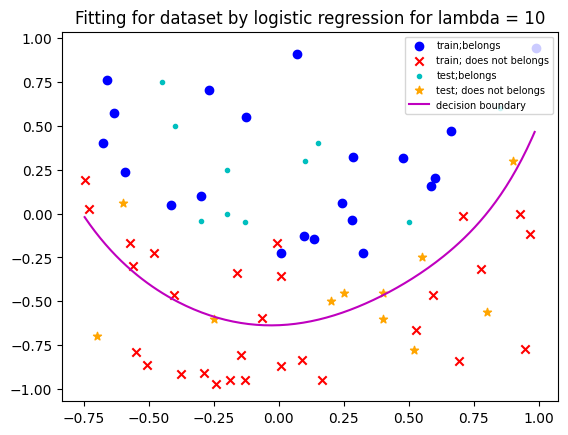

In [130]:
# theta 9 dim
lambda_array=[0.01, 0.05, 0.1, 0.5, 1, 10] # lambdas to test
for lambda_ in lambda_array:
    calculate_and_visualize_(lambda_)

## Iris dataset
Import essential libraries and dataset

In [131]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, classification_report

 
data = load_iris()
x = data.data
y = data.target

Splitting data into two subsets, normalize

In [132]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=12345)

standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

Model optimalization and data evaluation (without regularization)

In [133]:
log_regr = LogisticRegression(penalty=None)
log_regr.fit(X_train, y_train)
y_train_probab = log_regr.predict_proba(X_train)
y_test_probabs = log_regr.predict_proba(X_test)
cost_train = log_loss(y_train, y_train_probab)
cost_test = log_loss(y_test, y_test_probabs)
y_test_pred = log_regr.predict(X_test)
print(f"costs without regularization: {round(cost_test, 5)}")
out_str = classification_report(y_test, y_test_pred)
print(out_str)

costs without regularization: 0.04103
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.94      0.97        17
           2       0.92      1.00      0.96        12

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



Implement nonlinearity into features to test how model works on expanded case

In [134]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=12345)

# sclae data
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

# add nonlinearity
poly_features = PolynomialFeatures(degree=6)
X_train = poly_features.fit_transform(X_train)
X_test = poly_features.transform(X_test) 

log_regr = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)
log_regr.fit(X_train, y_train)
y_train_probab = log_regr.predict_proba(X_train)
y_test_probabs = log_regr.predict_proba(X_test)
cost_train = log_loss(y_train, y_train_probab)
cost_test = log_loss(y_test, y_test_probabs)
y_test_pred = log_regr.predict(X_test)
print(f"costs without regularization, with nonlinearity: {round(cost_test, 5)}")
out_str = classification_report(y_test, y_test_pred)
print(out_str)

costs without regularization, with nonlinearity: 1.08163
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.88      0.94        17
           2       0.86      1.00      0.92        12

    accuracy                           0.96        45
   macro avg       0.95      0.96      0.95        45
weighted avg       0.96      0.96      0.96        45



*cost value for nonlinear case is much bigger*

Case with regularization

In [135]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=12345)

standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

poly_features = PolynomialFeatures(degree=6)
X_train = poly_features.fit_transform(X_train)
X_test = poly_features.transform(X_test) 

# XXX parameter C controls strength of regularization, C=1 is moderate strength of regularization
log_regr = LogisticRegression(penalty='l2', C=1, max_iter=200)
log_regr.fit(X_train, y_train)
y_train_probab = log_regr.predict_proba(X_train)
y_test_probabs = log_regr.predict_proba(X_test)
cost_train = log_loss(y_train, y_train_probab)
cost_test = log_loss(y_test, y_test_probabs)
y_test_pred = log_regr.predict(X_test)
print(f"costs with regularization, nonlinearity included: {round(cost_test, 5)}")
out_str = classification_report(y_test, y_test_pred)
print(out_str)

costs with regularization, nonlinearity included: 0.0622
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        17
           2       1.00      1.00      1.00        12

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



*Despite better Precision and Recall metrics, the cost function value is slightly higher compared to the linear model, suggesting that the linear model was more confident in its decisions (hypothesis h(x) "closer" to zeros and ones from the value set), yet the non-linearity of the model above led to better effectiveness.*